# Load Packages

In [ ]:
import spotipy
from spotipy.oauth2 import SpotifyOAuth
import os
import sys
import pandas as pd
import numpy as np
import requests
from spotify_dl import spotify_dl
from pathlib import Path
import time
import os
from dotenv import load_dotenv # changed magic command to explicit load
import librosa
import matplotlib.pyplot as plt

pd.set_option("display.max_rows", None) # pandas dataframe formatting options
pd.set_option("display.max_columns", None)
pd.options.display.float_format = "{:,.2f}".format


custom_env_path = '../../brainstation_capstone_cfg.env' # environment variables file

In order to use the `spotify_dl` package to download the tracks that will comprise the dataset, a Spotify Web API app had to be created. From that app, the client ID and client secret were obtained and placed into the `brainstation_capstone_cfg.env` file. This file is then pulled into the present environment using the `python-dotenv` package via the magic command `%dotenv ../brainstation_capstone_cfg.env` above. The `spotify_dl` package also leverages another package known as `spotipy` and requires the `SPOTIPY_CLIENT_ID` and `SPOTIPY_CLIENT_SECRET` before it can begin downloading tracks. The credentials were stored within the external environment file which is not included within the repo for security reasons. In order to run this code, that information will be required. To obtain credentials please go to https://developer.spotify.com/documentation/web-api and follow the instructions under the 'Getting Started' section.

In [ ]:
# Spotify Developer Credentials
load_dotenv(dotenv_path = custom_env_path)
CLIENT_ID = os.environ.get("SPOTIPY_CLIENT_ID") 
# client ID from app
CLIENT_SECRET =  os.environ.get("SPOTIPY_CLIENT_SECRET") 
# client secret from app
REDIRECT_URI = os.environ.get('REDIRECT_URI') 
# redirect URI - the URI used here matches the one used within the app
SCOPE= "{} {}".format(os.environ.get('SCOPE_PUBLIC'),os.environ.get('SCOPE_PRIVATE'))
# formatted the scope this way to allow for custom configurations in the future
USERNAME = os.environ.get('SPOTIFY_USERNAME')
# Spotify username

# Data Acquisition

## MP3 Downloader

In [ ]:
file_path = '/Users/vii/repos/brainstation_capstone/data/mp3s/'
base_url = 'https://open.spotify.com/track/'
track_dirs =[]
dirs =[]
files = []
for root, dir, file in os.walk(file_path):
    dirs.append(dir)
    files.append(file)
    if len(dirs)>0:
        track_dirs = dirs[0].copy()
len(track_dirs)

In [ ]:
mp3s = [mp3[0] for mp3 in files if len(mp3)>0 and 'mp3' in mp3[0]]

In [ ]:
len(mp3s)

Output from code cell below looks like this:
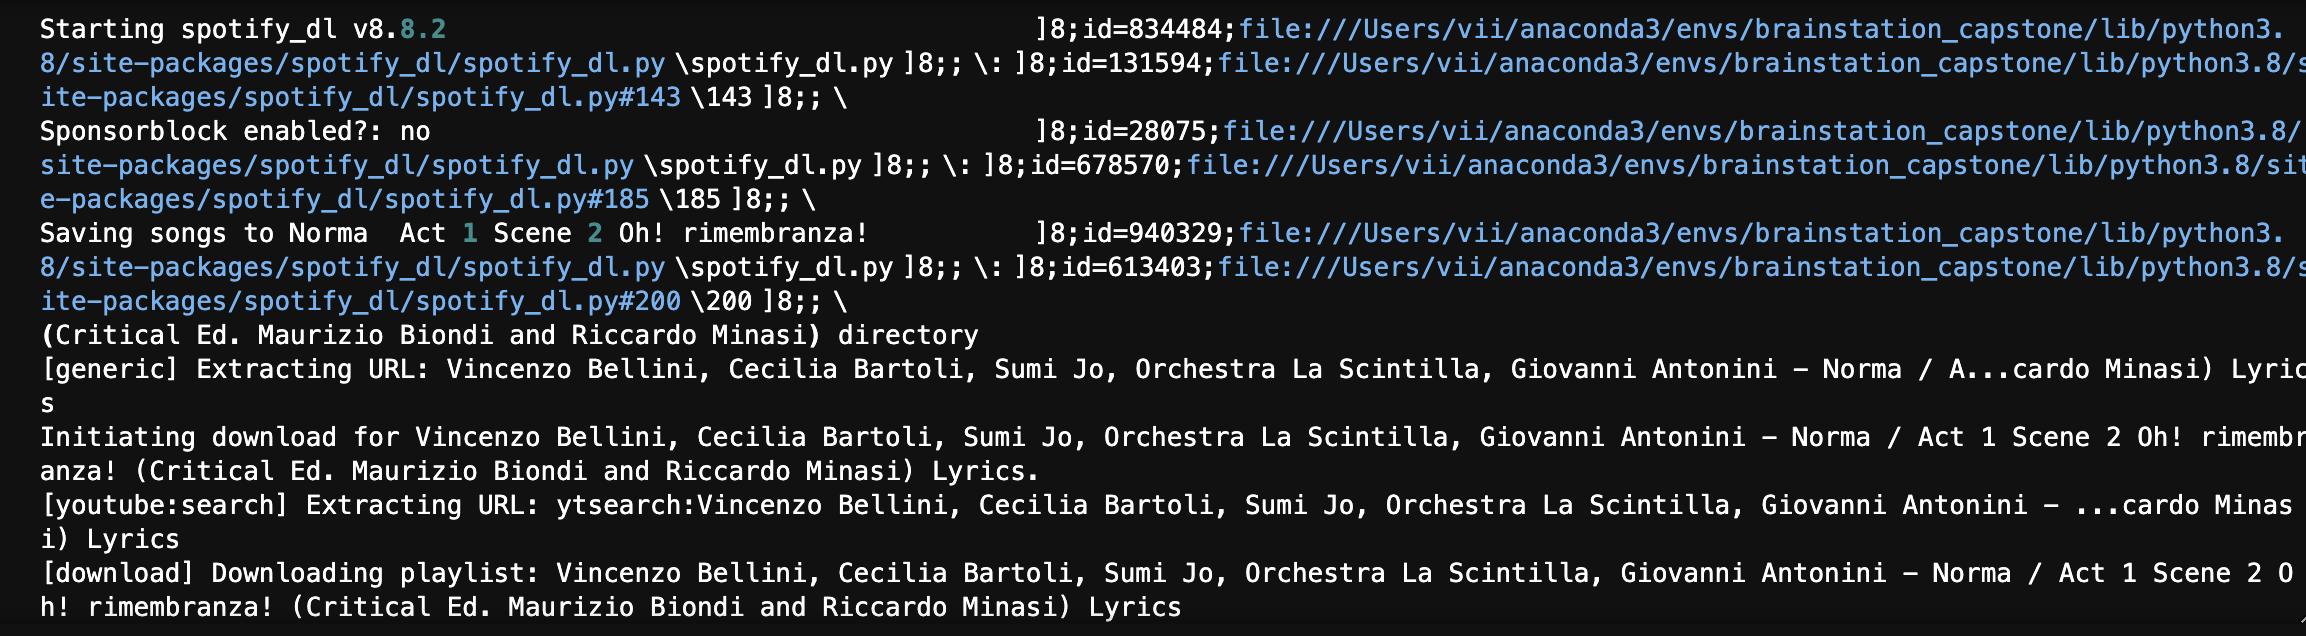

In [ ]:
os.system("export SPOTIPY_CLIENT_ID={}".format(CLIENT_ID))
os.system('export SPOTIPY_CLIENT_SECRET={}'.format(CLIENT_SECRET))
count = 0
while count<12000:
    for track_id in track_ids:
        if (len(track_dirs)>0) & (track_id in track_dirs):
            count+=1
            print(f'{count}: {track_id} already downloaded...skipping....')
        else:
            url = base_url+track_id    
            os.system("spotify_dl --url {} -o ../data/mp3s/{}".format(url,track_id))
            count+=1
            time.sleep(10) # 10 second delay between requests

# Exploratory Data Analysis (EDA)

## Kaggle Dataset Exploration

The dataset from Kaggle is read in below. The data contains 232,725 rows which is comprised of 176,774 unique track_ids. A random sample of 30,000 rows is extracted below. From these 28,622 unique track_ids are present. The unique track_ids are stripped of trailing and leading spaces before being put into a list for looping. More investigation into the Kaggle dataset can be found in the notebook 20230719_kaggle_data_spotify_tracks.ipynb which is also found within this directory.

In [ ]:
kaggle_df = pd.read_csv("../data/SpotifyFeatures.csv")
track_ids = kaggle_df.sample(30000, random_state = 123).track_id.str.strip().unique().tolist()
len(track_ids)

In [ ]:
df.genre.value_counts(normalize=True) * 100  # relatively good balance between genres

In [ ]:
df.duration_ms.value_counts(bins=20) # most songs are of a short duration, but there are some clear outliers that are much longer

In [ ]:
df.track_id.nunique() # there are fewer track ids than there are rows

In [ ]:
df.track_id.value_counts(ascending=False).head() # some of the track_ids appear more than once
# This seemed odd considering that the track_id should be a unique identifier.

In [ ]:
df.loc[df.track_id == "3R73Y7X53MIQZWnKloWq5i"]
# This shows that a single track id does correspond to a single song, but that the song can repeat within the data set
# based on the genre. All of the other columns are the same though.

In [ ]:
df.loc[df.track_id == "2qtoRFCOEL1gRn5q9DJC7F"]

It seems that the track_id is a unique identifier, but there are tracks that are duplicated across genre. This could be a biproduct of how the data was originally obtained.

In [ ]:
df.loc[df.popularity > 20].sort_values(by="popularity", ascending=False).shape[
    0
] / df.shape[0] * 100
# roughly 86% of the dataset is above a popularity score of 20
# this means that ~14% is below 20

## Librosa Spectrograms

In [ ]:
def get_melspectrogram(wav_file_path):
  y, sr = librosa.load(wav_file_path, offset=10, duration=240)
  melspectrogram = np.array(librosa.feature.melspectrogram(y=y, sr=sr))
  return melspectrogram

def get_chroma_vector(wav_file_path):
  y, sr = librosa.load(wav_file_path)
  chroma = np.array(librosa.feature.chroma_stft(y=y, sr=sr))
  return chroma

def get_tonnetz(wav_file_path):
  y, sr = librosa.load(wav_file_path)
  tonnetz = np.array(librosa.feature.tonnetz(y=y, sr=sr))
  return tonnetz

In [ ]:
example_file = '/Users/vii/repos/brainstation_capstone/data/mp3s/1ZB2qWsheGabSEYvBYxjKn/Take on Me/Weezer - Take on Me.mp3'

In [ ]:
# Loudness Profile?
# https://medium.com/analytics-vidhya/understanding-the-mel-spectrogram-fca2afa2ce53
# https://librosa.org/doc/latest/generated/librosa.feature.melspectrogram.html
melspectrogram = get_melspectrogram(example_file)
plt.imshow(melspectrogram, interpolation='nearest', aspect='auto')
plt.show()

In [ ]:
# Pitch-class profile
# https://en.wikipedia.org/wiki/Chroma_feature
# https://librosa.org/doc/latest/generated/librosa.feature.chroma_stft.html
chroma = get_chroma_vector(example_file)
plt.imshow(chroma, interpolation='nearest', aspect='auto')
plt.show()

In [ ]:
# Harmonic Relationships (Tonnetz)
# https://en.wikipedia.org/wiki/Tonnetz
# https://librosa.org/doc/latest/generated/librosa.feature.tonnetz.html
tntz = get_tonnetz(example_file)
plt.imshow(tntz , interpolation='nearest', aspect='auto')
plt.show()

In [ ]:
example_file = '/Users/vii/repos/brainstation_capstone/data/mp3s/1cjvpB46mcjPIt9KFktKwk/Rigoletto  Act 2 Cortigiani, vil razza dannata...Ebben piango/Giuseppe Verdi, Sherrill Milnes, London Symphony Orchestra, Richard Bonynge - #Rigoletto # Act 2# ##Cortigiani, vil razza dannata...Ebben piango###.mp3'

In [ ]:
# Loudness Profile?
# https://medium.com/analytics-vidhya/understanding-the-mel-spectrogram-fca2afa2ce53
# https://librosa.org/doc/latest/generated/librosa.feature.melspectrogram.html
melspectrogram = get_melspectrogram(example_file)
plt.imshow(melspectrogram, interpolation='nearest', aspect='auto')
plt.show()

In [ ]:
# Pitch-class profile
# https://en.wikipedia.org/wiki/Chroma_feature
# https://librosa.org/doc/latest/generated/librosa.feature.chroma_stft.html
chroma = get_chroma_vector(example_file)
plt.imshow(chroma, interpolation='nearest', aspect='auto')
plt.show()

In [ ]:
# Harmonic Relationships (Tonnetz)
# https://en.wikipedia.org/wiki/Tonnetz
# https://librosa.org/doc/latest/generated/librosa.feature.tonnetz.html
tntz = get_tonnetz(example_file)
plt.imshow(tntz , interpolation='nearest', aspect='auto')
plt.show()

In [ ]:
# Initialize SpotifyOAuth
sp_oauth = SpotifyOAuth(
    client_id=CLIENT_ID,
    client_secret=CLIENT_SECRET,
    redirect_uri=REDIRECT_URI,
    scope=SCOPE,
    cache_path=".cache",
    show_dialog=False
)

def main():
    # Get cached token or start authorization process
    access_token_info = sp_oauth.get_cached_token()
    if access_token_info:
        access_token = access_token_info['access_token']
    else:
        print("Authorization required. Visit the following URL to authorize:")
        auth_url = sp_oauth.get_authorize_url()
        print(auth_url)
        return

    # Initialize spotipy with access token
    sp = spotipy.Spotify(auth=access_token)

    # Replace 'Your Username' with your Spotify username
    username = USERNAME
    playlist_name = 'My AWESOME Playlist 2'
    playlist_description = 'Demo for Paul'

    try:
        # Create a blank playlist
        playlist = sp.user_playlist_create(
            user=username,
            name=playlist_name,
            description = playlist_description,
            public=False
        )
        print(f"Playlist '{playlist_name}' was created")
    except spotipy.SpotifyException as e:
        print(f"An error occurred: {e}")
    
if __name__ == '__main__':
    main()